In [7]:
# === IMPORTS ===
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import open_clip

# === LABELS & PATHS ===
DATA_ROOT = 'mini_dataset_100'  # or mini_dataset_4000
IMAGE_BASE = os.path.join(DATA_ROOT, 'images')

label_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
    'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]

# === LOAD DATA ===
train_df = pd.read_csv(os.path.join(DATA_ROOT, 'train_data.csv'))
test_df = pd.read_csv(os.path.join(DATA_ROOT, 'test_data.csv'))

train_df['image_path'] = train_df['dicom_id'].apply(lambda x: f'{IMAGE_BASE}/{x}.jpg')
test_df['image_path'] = test_df['dicom_id'].apply(lambda x: f'{IMAGE_BASE}/{x}.jpg')

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# === LOAD BiomedCLIP FROM open_clip ===
clip_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)

# === DATASET ===
class CLIPDataset(Dataset):
    def __init__(self, df, preprocess):
        self.df = df.reset_index(drop=True)
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")
        image = self.preprocess(image)
        label = torch.tensor(row[label_cols].values.astype(np.float32))
        return image, label

# === MODEL: ViT + LINEAR HEAD ===
class CLIPMultiLabelClassifier(nn.Module):
    def __init__(self, clip_model, embed_dim=512, num_labels=14):
        super().__init__()
        self.clip_model = clip_model.visual
        self.classifier = nn.Linear(embed_dim, num_labels)

    def forward(self, images):
        features = self.clip_model(images)  # (B, D)
        return self.classifier(features)

# === DATALOADERS ===
BATCH_SIZE = 16


balanced_df = pd.read_csv(os.path.join(DATA_ROOT, 'train_data_balanced.csv'))
train_dataset = CLIPDataset(balanced_df, preprocess_train)

# train_dataset = CLIPDataset(train_df, preprocess_train)
val_dataset = CLIPDataset(val_df, preprocess_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 8)

# === TRAIN FUNCTION ===
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# === EVALUATE FUNCTION ===
def evaluate(model, dataloader, criterion, device):
    model.eval()
    all_labels = []
    all_logits = []
    total_loss = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            all_labels.append(labels.cpu())
            all_logits.append(logits.cpu())

    labels = torch.cat(all_labels)
    outputs = torch.cat(all_logits)
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).int()

    f1 = f1_score(labels, preds, average='macro')
    auc = roc_auc_score(labels, probs, average='macro')

    return total_loss / len(dataloader), f1, auc

# === TRAINING LOOP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPMultiLabelClassifier(clip_model, embed_dim=512, num_labels=len(label_cols)).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

In [6]:
print("Train set:", balanced_df.shape)
print("Test set:", test_df.shape)
print("Disease label distribution in train set:\n", balanced_df['disease_label'].value_counts())
print("Disease label distribution in test set:\n", test_df['disease_label'].value_counts())

Train set: (4275, 28)
Test set: (782, 28)
Disease label distribution in train set:
 14    1116
1      910
2      521
8      328
9      179
3      171
0      150
6      147
13     136
7      133
4      123
5      118
11      96
10      80
12      67
Name: disease_label, dtype: int64
Disease label distribution in test set:
 14    289
1     133
2      91
8      58
0      52
4      50
3      21
13     19
7      15
9      13
6      12
5      10
10     10
11      5
12      4
Name: disease_label, dtype: int64


In [8]:
EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_f1, val_auc = evaluate(model, val_loader, criterion, device)
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f}")

[Epoch 1] Train Loss: 0.3339 | Val Loss: 0.2619 | F1: 0.2433 | AUC: 0.8140
[Epoch 2] Train Loss: 0.2578 | Val Loss: 0.2230 | F1: 0.3404 | AUC: 0.8805
[Epoch 3] Train Loss: 0.2006 | Val Loss: 0.2082 | F1: 0.5851 | AUC: 0.9329
[Epoch 4] Train Loss: 0.1540 | Val Loss: 0.1463 | F1: 0.7094 | AUC: 0.9658
[Epoch 5] Train Loss: 0.1088 | Val Loss: 0.1128 | F1: 0.7959 | AUC: 0.9815
[Epoch 6] Train Loss: 0.0772 | Val Loss: 0.0856 | F1: 0.8648 | AUC: 0.9916
[Epoch 7] Train Loss: 0.0553 | Val Loss: 0.0693 | F1: 0.9004 | AUC: 0.9928
[Epoch 8] Train Loss: 0.0375 | Val Loss: 0.0689 | F1: 0.8831 | AUC: 0.9953
[Epoch 9] Train Loss: 0.0316 | Val Loss: 0.0505 | F1: 0.9204 | AUC: 0.9967
[Epoch 10] Train Loss: 0.0260 | Val Loss: 0.0413 | F1: 0.9390 | AUC: 0.9980
[Epoch 11] Train Loss: 0.0199 | Val Loss: 0.0463 | F1: 0.9414 | AUC: 0.9982
[Epoch 12] Train Loss: 0.0179 | Val Loss: 0.0382 | F1: 0.9318 | AUC: 0.9981
[Epoch 13] Train Loss: 0.0193 | Val Loss: 0.0408 | F1: 0.9473 | AUC: 0.9986
[Epoch 14] Train Loss

In [9]:
torch.save(model.state_dict(), "finetuned_biomedclip_chestx.pt")

In [ ]:
# model = CLIPMultiLabelClassifier(clip_model, embed_dim=512, num_labels=14)
# model.load_state_dict(torch.load("finetuned_biomedclip_chestx.pt"))
# model.to(device)

In [2]:
import pandas as pd

# # === Load the balanced CSV ===
# DATA_ROOT = 'mini_dataset_100'  # or 'mini_dataset_4000'
# balanced_df = pd.read_csv(f"{DATA_ROOT}/train_data_balanced.csv")

# # === Define your 14 labels ===
# label_cols = [
#     'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
#     'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
#     'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
# ]

# === Count number of samples containing each label ===
label_counts = balanced_df[label_cols].sum().astype(int).sort_values(ascending=False)

# === Print neatly ===
print("Label distribution (number of samples containing each condition):")
print(label_counts)


Label distribution (number of samples containing each condition):
No Finding                    1229
Lung Opacity                  1073
Support Devices               1011
Pleural Effusion               987
Atelectasis                    910
Cardiomegaly                   809
Pneumonia                      393
Enlarged Cardiomediastinum     334
Edema                          332
Consolidation                  331
Lung Lesion                    314
Pneumothorax                   307
Fracture                       300
Pleural Other                  300
dtype: int64


In [10]:
model.eval()
test_dataset = CLIPDataset(test_df, preprocess_val)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers = 8)

all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        all_probs.append(probs.cpu())

all_probs = torch.cat(all_probs).numpy()
test_preds = (all_probs > 0.5).astype(int)

# Export to CSV
pred_df = test_df[['dicom_id']].copy()
for i, label in enumerate(label_cols):
    pred_df[label] = test_preds[:, i]

pred_df.to_csv("biomedclip_test_predictions.csv", index=False)


In [2]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# === Paths ===
DATA_ROOT = 'mini_dataset_100'  # or mini_dataset_4000
label_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
    'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]

# === Load Data ===
gt_df = pd.read_csv(os.path.join(DATA_ROOT, 'test_data.csv'))  # Ground truth
pred_df = pd.read_csv('biomedclip_test_predictions.csv')       # Predictions

# === Merge on dicom_id ===
merged_df = gt_df.merge(pred_df, on='dicom_id', suffixes=('_true', '_pred'))


In [12]:
y_true = merged_df[[f"{col}_true" for col in label_cols]].values
y_pred = merged_df[[f"{col}_pred" for col in label_cols]].values


In [13]:
# Overall macro F1 score
f1 = f1_score(y_true, y_pred, average='macro')

# Overall macro AUC (handle exception for labels with no positives)
try:
    auc = roc_auc_score(y_true, y_pred, average='macro')
except:
    auc = 'undefined (some labels missing)'

# Full report
report = classification_report(y_true, y_pred, target_names=label_cols, zero_division=0)

print("==== Classification Report ====")
print(report)
print(f"\nMacro F1 Score: {f1:.4f}")
print(f"Macro AUC Score: {auc}")


==== Classification Report ====
                            precision    recall  f1-score   support

               Atelectasis       0.28      0.15      0.20       133
              Cardiomegaly       0.33      0.24      0.28       126
             Consolidation       0.25      0.03      0.06        29
                     Edema       0.28      0.16      0.21        86
Enlarged Cardiomediastinum       0.00      0.00      0.00        19
                  Fracture       0.00      0.00      0.00        16
               Lung Lesion       0.00      0.00      0.00        18
              Lung Opacity       0.32      0.35      0.34       147
                No Finding       0.63      0.53      0.58       302
          Pleural Effusion       0.46      0.61      0.52       126
             Pleural Other       0.00      0.00      0.00         6
                 Pneumonia       0.27      0.05      0.08        60
              Pneumothorax       0.20      0.08      0.12        12
           Supp

In [3]:
# === IMPORTS ===
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import open_clip

# === CONFIG ===
DATA_ROOT = 'mini_dataset_100'
IMAGE_BASE = os.path.join(DATA_ROOT, 'images')
BATCH_SIZE = 16
label_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
    'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]

# === LOAD AND SPLIT ORIGINAL DATA ===
original_df = pd.read_csv(os.path.join(DATA_ROOT, 'train_data.csv'))
original_df['image_path'] = original_df['dicom_id'].apply(lambda x: f'{IMAGE_BASE}/{x}.jpg')

# Split BEFORE balancing
raw_train_df, val_df = train_test_split(original_df, test_size=0.2, random_state=42, stratify=original_df['No Finding'])

# === LOAD Balanced Training Data ===
balanced_df = pd.read_csv(os.path.join(DATA_ROOT, 'train_data_balanced.csv'))

# === PREPROCESSOR ===
clip_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)

# === DATASET CLASS ===
class CLIPDataset(Dataset):
    def __init__(self, df, preprocess):
        self.df = df.reset_index(drop=True)
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")
        image = self.preprocess(image)
        label = torch.tensor(row[label_cols].values.astype(np.float32))
        return image, label

# === MODEL CLASS ===
class CLIPMultiLabelClassifier(nn.Module):
    def __init__(self, clip_model, embed_dim=512, num_labels=14):
        super().__init__()
        self.clip_model = clip_model.visual
        self.classifier = nn.Linear(embed_dim, num_labels)

    def forward(self, images):
        features = self.clip_model(images)
        return self.classifier(features)

# === LOADERS ===
train_dataset = CLIPDataset(balanced_df, preprocess_train)
val_dataset = CLIPDataset(val_df, preprocess_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# === TRAIN FUNCTION ===
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# === EVALUATE FUNCTION (returns raw probs and labels) ===
def evaluate(model, dataloader, criterion, device):
    model.eval()
    all_labels, all_logits = [], []
    total_loss = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            all_labels.append(labels.cpu())
            all_logits.append(logits.cpu())

    labels = torch.cat(all_labels)
    outputs = torch.cat(all_logits)
    probs = torch.sigmoid(outputs)
    return total_loss / len(dataloader), probs.numpy(), labels.numpy()

# === THRESHOLD TUNING ===
def tune_thresholds(y_true, y_probs, label_cols):
    best_thresholds = []
    for i in range(len(label_cols)):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_thresh = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else 0.5
        best_thresholds.append(best_thresh)
        print(f"{label_cols[i]:<25} | Best threshold: {best_thresh:.3f}")
    return np.array(best_thresholds)

# === TRAINING LOOP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPMultiLabelClassifier(clip_model, embed_dim=512, num_labels=len(label_cols)).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

In [4]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_probs, val_labels = evaluate(model, val_loader, criterion, device)

    val_preds = (val_probs > 0.5).astype(int)
    f1 = f1_score(val_labels, val_preds, average='macro')
    auc = roc_auc_score(val_labels, val_probs, average='macro')

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

# === FINAL THRESHOLD TUNING (OPTIONAL) ===
print("\n🔍 Optimal per-label thresholds:")
thresholds = tune_thresholds(val_labels, val_probs, label_cols)

[Epoch 1] Train Loss: 0.3321 | Val Loss: 0.2685 | F1: 0.2422 | AUC: 0.8167
[Epoch 2] Train Loss: 0.2532 | Val Loss: 0.2156 | F1: 0.4038 | AUC: 0.8916
[Epoch 3] Train Loss: 0.1962 | Val Loss: 0.1778 | F1: 0.5523 | AUC: 0.9324
[Epoch 4] Train Loss: 0.1504 | Val Loss: 0.1567 | F1: 0.7205 | AUC: 0.9593
[Epoch 5] Train Loss: 0.1098 | Val Loss: 0.1137 | F1: 0.7859 | AUC: 0.9768
[Epoch 6] Train Loss: 0.0757 | Val Loss: 0.0950 | F1: 0.8522 | AUC: 0.9883
[Epoch 7] Train Loss: 0.0542 | Val Loss: 0.0645 | F1: 0.9154 | AUC: 0.9934
[Epoch 8] Train Loss: 0.0427 | Val Loss: 0.0561 | F1: 0.9325 | AUC: 0.9963
[Epoch 9] Train Loss: 0.0349 | Val Loss: 0.0439 | F1: 0.9358 | AUC: 0.9974
[Epoch 10] Train Loss: 0.0224 | Val Loss: 0.0476 | F1: 0.9252 | AUC: 0.9983

🔍 Optimal per-label thresholds:
Atelectasis               | Best threshold: 0.123
Cardiomegaly              | Best threshold: 0.155
Consolidation             | Best threshold: 0.468
Edema                     | Best threshold: 0.197
Enlarged Cardiom

In [5]:
# === SAVE MODEL & THRESHOLDS ===
model_path = os.path.join(DATA_ROOT, "finetuned_biomedclip_model.pt")
threshold_path = os.path.join(DATA_ROOT, "optimal_thresholds.npy")

torch.save(model.state_dict(), model_path)
np.save(threshold_path, thresholds)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Thresholds saved to: {threshold_path}")


✅ Model saved to: mini_dataset_100/finetuned_biomedclip_model.pt
✅ Thresholds saved to: mini_dataset_100/optimal_thresholds.npy


In [6]:
# === LOAD SAVED MODEL AND THRESHOLDS ===
loaded_model = CLIPMultiLabelClassifier(clip_model, embed_dim=512, num_labels=len(label_cols)).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

thresholds = np.load(threshold_path)


/tmp/ipykernel_5404/1639366434.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


In [7]:
# === PREPARE TEST SET ===
test_df = pd.read_csv(os.path.join(DATA_ROOT, 'test_data.csv'))
test_df['image_path'] = test_df['dicom_id'].apply(lambda x: f'{IMAGE_BASE}/{x}.jpg')
test_dataset = CLIPDataset(test_df, preprocess_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# === RUN INFERENCE ===
all_test_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        logits = loaded_model(images)
        probs = torch.sigmoid(logits).cpu()
        all_test_probs.append(probs)

# === STACK AND APPLY THRESHOLDS ===
all_test_probs = torch.cat(all_test_probs).numpy()
test_preds = (all_test_probs > thresholds).astype(int)

# === EXPORT PREDICTIONS ===
output_df = test_df[['dicom_id']].copy()
for i, label in enumerate(label_cols):
    output_df[label] = test_preds[:, i]

output_path = os.path.join(DATA_ROOT, 'biomedclip_test_predictions.csv')
output_df.to_csv(output_path, index=False)
print(f"✅ Test predictions saved to: {output_path}")


✅ Test predictions saved to: mini_dataset_100/biomedclip_test_predictions.csv


In [8]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score

# === Load ground truth and predictions ===
gt_df = pd.read_csv(os.path.join(DATA_ROOT, 'test_data.csv'))
pred_df = pd.read_csv(os.path.join(DATA_ROOT, 'biomedclip_test_predictions.csv'))

# === Merge by dicom_id ===
merged_df = gt_df.merge(pred_df, on='dicom_id', suffixes=('_true', '_pred'))

# === Extract arrays ===
y_true = merged_df[[f"{col}_true" for col in label_cols]].values
y_pred = merged_df[[f"{col}_pred" for col in label_cols]].values

# === Compute metrics ===
f1_macro = f1_score(y_true, y_pred, average='macro')
try:
    auc_macro = roc_auc_score(y_true, y_pred, average='macro')
except:
    auc_macro = "undefined (some labels may lack positives)"

report = classification_report(y_true, y_pred, target_names=label_cols, zero_division=0)

# === Print ===
print("==== Test Classification Report ====")
print(report)
print(f"Macro F1 Score:  {f1_macro:.4f}")
print(f"Macro AUC Score: {auc_macro}")


==== Test Classification Report ====
                            precision    recall  f1-score   support

               Atelectasis       0.34      0.18      0.24       133
              Cardiomegaly       0.39      0.21      0.28       126
             Consolidation       0.00      0.00      0.00        29
                     Edema       0.41      0.44      0.42        86
Enlarged Cardiomediastinum       0.00      0.00      0.00        19
                  Fracture       0.00      0.00      0.00        16
               Lung Lesion       0.00      0.00      0.00        18
              Lung Opacity       0.32      0.29      0.30       147
                No Finding       0.63      0.60      0.61       302
          Pleural Effusion       0.49      0.68      0.57       126
             Pleural Other       0.00      0.00      0.00         6
                 Pneumonia       0.04      0.02      0.02        60
              Pneumothorax       0.15      0.17      0.16        12
          

In [9]:
from matplotlib import pyplot as plt

def visualize_errors(test_df, y_true, y_pred, label_cols, n=5):
    mismatches = np.where((y_true != y_pred).sum(axis=1) > 0)[0]
    for idx in mismatches[:n]:
        img_path = test_df.iloc[idx]['image_path']
        true_labels = [label_cols[i] for i in range(len(label_cols)) if y_true[idx, i] == 1]
        pred_labels = [label_cols[i] for i in range(len(label_cols)) if y_pred[idx, i] == 1]
        image = Image.open(img_path).convert("L")
        plt.imshow(image, cmap='gray')
        plt.title(f"T: {true_labels}\nP: {pred_labels}", fontsize=10)
        plt.axis('off')
        plt.show()


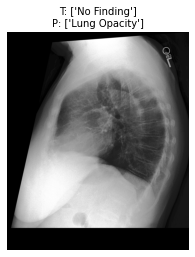

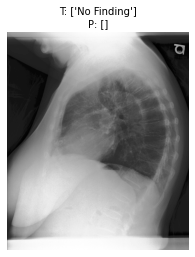

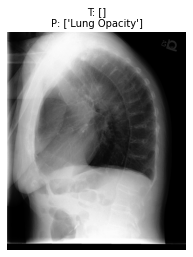

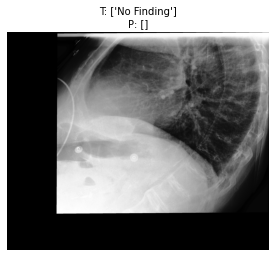

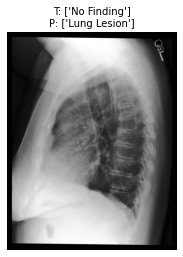

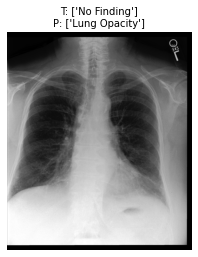

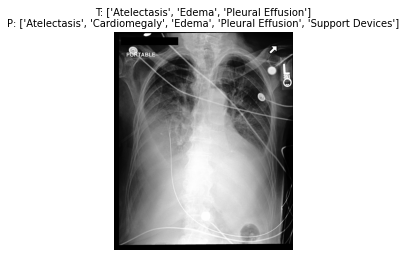

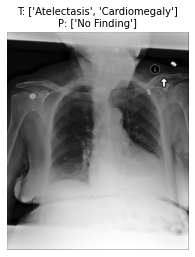

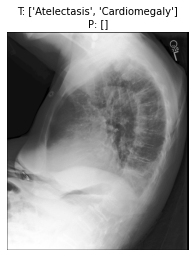

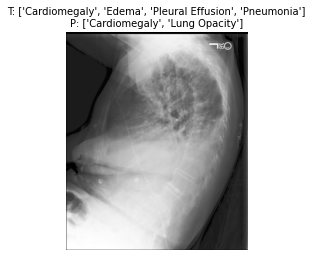

In [10]:
visualize_errors(test_df, y_true, y_pred, label_cols, n=10)

In [23]:
# === 1. IMPORTS ===
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from transformers import BioGptTokenizer, BioGptForCausalLM
import open_clip

# === 2. CONFIG ===
IMAGE_DIR = "mini_dataset_100/images"
REPORT_DIR = "mini_dataset_100/reports"
SPLITS_FILE = "mini_dataset_100/splits.csv"
MAX_LENGTH = 256
BATCH_SIZE = 4
EPOCHS = 5
EMBED_DIM = 768  # BiomedCLIP vit_base_patch16_224

# === 3. LOAD AND MERGE DATA ===
splits_df = pd.read_csv(SPLITS_FILE)

# Match dicom_id -> image, study_id -> report
rows = []
for _, row in splits_df.iterrows():
    study_id = str(row["study_id"])
    dicom_id = row["dicom_id"]
    image_path = os.path.join(IMAGE_DIR, f"{dicom_id}.jpg")
    report_path = os.path.join(REPORT_DIR, f"s{study_id}.txt")  # prefix 's'

    if os.path.exists(image_path) and os.path.exists(report_path):
        with open(report_path, "r", encoding="utf-8") as f:
            report_text = f.read().strip()
        if report_text:
            rows.append({
                "image_path": image_path,
                "report": report_text
            })

df = pd.DataFrame(rows)
print(f"✅ Total training pairs: {len(df)}")

# === 4. LOAD MODELS ===
clip_model, _, preprocess = open_clip.create_model_and_transforms(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)
tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")
biogpt = BioGptForCausalLM.from_pretrained("microsoft/biogpt")

# === 5. DATASET ===
class ImageReportDataset(Dataset):
    def __init__(self, df, preprocess, tokenizer, max_length=256):
        self.df = df.reset_index(drop=True)
        self.preprocess = preprocess
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")
        image = self.preprocess(image)

        encoded = self.tokenizer(
            row['report'],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        return {
            "image": image,
            "input_ids": encoded.input_ids.squeeze(0),
            "attention_mask": encoded.attention_mask.squeeze(0)
        }

# === 6. MODEL ===
class CLIP2BioGPT(nn.Module):
    def __init__(self, vision_encoder, text_decoder):
        super().__init__()
        self.vision_encoder = vision_encoder.visual
        self.text_decoder = text_decoder
        self.proj = nn.Linear(512, text_decoder.config.hidden_size)  # FIXED: from 768 to 512

    def forward(self, images, input_ids, attention_mask):
        image_features = self.vision_encoder(images)  # output: (B, 512)
        encoder_hidden = self.proj(image_features).unsqueeze(1)     # becomes (B, 1, hidden_size)
        outputs = self.text_decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden,
            encoder_attention_mask=torch.ones(encoder_hidden.shape[:2]).to(encoder_hidden.device)
        )
        return outputs



# === 7. TRAINING LOOP ===
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(images, input_ids, attention_mask)
        logits = outputs.logits
        loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), input_ids.view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    return total_loss / len(dataloader)

✅ Total training pairs: 4000


Error during conversion: ChunkedEncodingError(ProtocolError("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read)))


In [24]:
# === 8. MAIN ===
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = ImageReportDataset(df, preprocess, tokenizer, MAX_LENGTH)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    model = CLIP2BioGPT(clip_model, biogpt).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    for epoch in range(EPOCHS):
        loss = train_epoch(model, dataloader, optimizer, device)
        print(f"[Epoch {epoch+1}] Loss: {loss:.4f}")

    torch.save(model.state_dict(), "clip2biogpt_model.pt")
    print("✅ Model saved to clip2biogpt_model.pt")

if __name__ == "__main__":
    main()

TypeError: forward() got an unexpected keyword argument 'encoder_hidden_states'